# Clusterização de Adverse Food Events #
### Notebook utilizado para tentar a clusterização usando os sintomas para tentar encontrar padrões com a área da indústria###

In [1]:
#imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from pandas import DataFrame
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN 
from sklearn.externals import joblib
from sklearn.decomposition import PCA
from sklearn.externals import joblib

In [2]:
data = pd.read_csv('./data/CAERS_ASCII_2004_2017Q2.csv')
#Renomeando Colunas para facilitar entendimento
data = data.rename(index=str, columns={"RA_Report #": "Report ID",
                                "RA_CAERS Created Date": "Created Date",
                                "AEC_Event Start Date": "Start Date",
                                "PRI_Product Role": "Product Role",
                                "PRI_Reported Brand/Product Name": "Brand/Product Name",
                                "PRI_FDA Industry Code": "Industry Code",
                                "PRI_FDA Industry Name":"Industry Name",
                                "CI_Age at Adverse Event":"Age",
                                "CI_Age Unit":"Age Unit",
                                "CI_Gender":"Gender",
                                "AEC_One Row Outcomes":"One Row Outcomes",
                                "SYM_One Row Coded Symptoms":"One Row Coded Symptoms"
                               })

In [3]:
#Sintomas
#Tratando e separando os sintomas
array_all_symptoms = np.concatenate( [str(symptom).split(',') for symptom in data['One Row Coded Symptoms']], axis=0 )
#Removendo alguns espaços
array_all_symptoms, counts = np.unique([o.lstrip() for o in array_all_symptoms], return_counts=True)
ordered_symptoms_count = pd.DataFrame({'Symptoms': array_all_symptoms, 'Count': counts}).sort_values(by='Count', ascending=False)
print('Identificamos',len(array_all_symptoms), 'sintomas')

Identificamos 4149 sintomas


In [5]:
#Apartir daqui iremos pegar a coluna com os sintomas e transformar cada sintoma em uma coluna para todas as linhas,
#ou seja, colocaremos 0 quando a linha não conter os sintoma e 1 quando o sintoma estiver presente naquela linha

#Quebra a string em uma array de sintomas
each_row_array = [str(symptom).split(',') for symptom in data['One Row Coded Symptoms']]

#remove alguns espaços do fim e do começo de alguns simtomas, para garantir que serão unicos
#Pois somente com a linha de cima teriamos alguns simtomas como: 'DEATH' e ' DEATH'.
each_row_array = [(','.join([symptom.lstrip() for symptom in row])) for row in each_row_array]
data['Proceced Symptoms'] = each_row_array #Aqui colocamos uma nova coluna no formato 'simpt1,simpt2..' para poder usar o get_dummies

### A célula abaixo determina qual dos fltros desejase usar.
### Sendo o primero para analisar somente as linhas que contenham os dois sintomas mais frequentes
### e a segunda para analisar o sintoma Fadiga.

In [6]:
#Como +-4100 sintomas são muitas dimensões, teremos de reduzir isso a menos para que
# seja feito em tempo hábil o One Hot Encoding

arr_symptom = []

#variavel para dois sintomas mais frequentes
symptoms_for_analyze = ordered_symptoms_count[:2] 
#variavel para FATIGUE symptom
symptoms_for_analyze = ordered_symptoms_count[15:16]

In [7]:
#faz array de sintomas mais frequentes
for i, symptom in symptoms_for_analyze.iterrows():
    arr_symptom.append(symptom['Symptoms'])

#Pega somente as linhas do dataset que contem os sintomas desejados na celula anterior
boolean_index_array = [] #array de boleanos para selecionar somente linhas que contenham os sintomas
for i,row in data.iterrows():
    symptoms_array = row['Proceced Symptoms'].split(',')
    boolean_index_array.append(bool(set(arr_symptom) & set(symptoms_array)))

In [8]:
##pega um dataframe somente com as entradas que contem os sintomas relevantes
data_relevant_symptoms = data[boolean_index_array]

data_one_hot_enc = data_relevant_symptoms['Proceced Symptoms'].str.get_dummies(sep=',')
joblib.dump(data_one_hot_enc, 'one_hot_enc.pkl') 

data_one_hot_enc = joblib.load('one_hot_enc.pkl')  #carrega o one hot enc ja feito
print("Dimensões do ONE HOT ENCODING:",data_one_hot_enc.shape)

Dimensões do ONE HOT ENCODING: (3408, 1252)


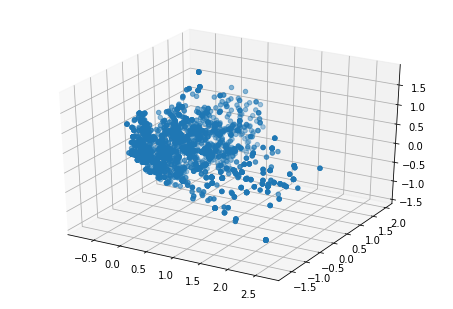

In [11]:
from mpl_toolkits.mplot3d import Axes3D

pca = PCA(n_components=3).fit(data_one_hot_enc)
pca_3d = pca.transform(data_one_hot_enc)

fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(pca_3d[:, 0], pca_3d[:, 1], pca_3d[:, 2])

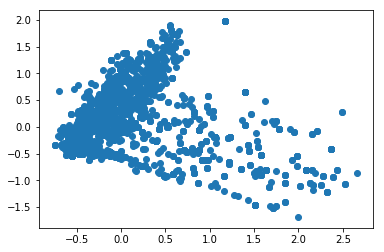

In [12]:
pca1 = PCA(n_components=2).fit(data_one_hot_enc)
pca_2d = pca1.transform(data_one_hot_enc)

fig = plt.figure()
plt.scatter(pca_2d[:, 0], pca_2d[:, 1])

#len(pca_3d[pca_3d[:0]])

In [14]:
from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.spatial.distance import cdist


# k means determine k
distortions = []
K = range(5,301,50)
for k in K:
    kmeanModel = KMeans(n_clusters=k).fit(data_one_hot_enc)
    kmeanModel.fit(data_one_hot_enc)
    distortions.append(sum(np.min(cdist(data_one_hot_enc, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / data_one_hot_enc.shape[0])

# Plot the elbow
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

KeyboardInterrupt: 

### Célula abaixo é onde se insere o número desejado do K(clusters)

In [15]:
num_clusters = 50
kmeanModel = KMeans(n_clusters=num_clusters).fit(data_one_hot_enc)
kmeanModel.fit(data_one_hot_enc)
joblib.dump(kmeanModel, 'kmeanModel_1_fatigue.pkl') 

['kmeanModel_1_fatigue.pkl']

/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


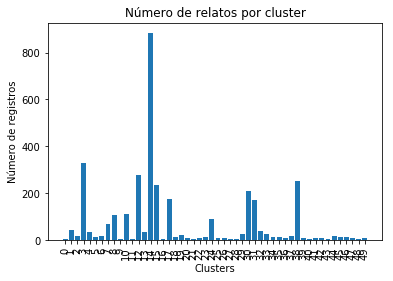

In [16]:
kmeanModel = joblib.load('kmeanModel_1_fatigue.pkl')  #carrega o one hot enc ja feito

data_relevant_symptoms['KMeans Group'] = kmeanModel.labels_

clusters, counts = np.unique(data_relevant_symptoms['KMeans Group'], return_counts = True)
ordered_clusters_count = pd.DataFrame({'Clusters': clusters, 'Count': counts}).sort_values(by='Count', ascending=False)

#Histograma dos resultados
plt.bar(ordered_clusters_count['Clusters'], ordered_clusters_count['Count'])
plt.gca().set_xticks(ordered_clusters_count['Clusters'])
plt.xticks(rotation=90)
plt.rcParams["figure.figsize"] = [16,9]
plt.xlabel('Clusters')
plt.ylabel('Número de registros')
plt.title('Número de relatos por cluster')
plt.show()

Cluster 0
   Count                                Industry
0      6  Vit/Min/Prot/Unconv Diet(Human/Animal)
Temos 38 sintomas
    Count                            Symptoms
0       6  ALANINE AMINOTRANSFERASE INCREASED
28      6  NUCLEAR MAGNETIC RESONANCE IMAGING
21      6                   HEPATIC STEATOSIS
22      6                    HYPERSENSITIVITY
23      6                              INJURY


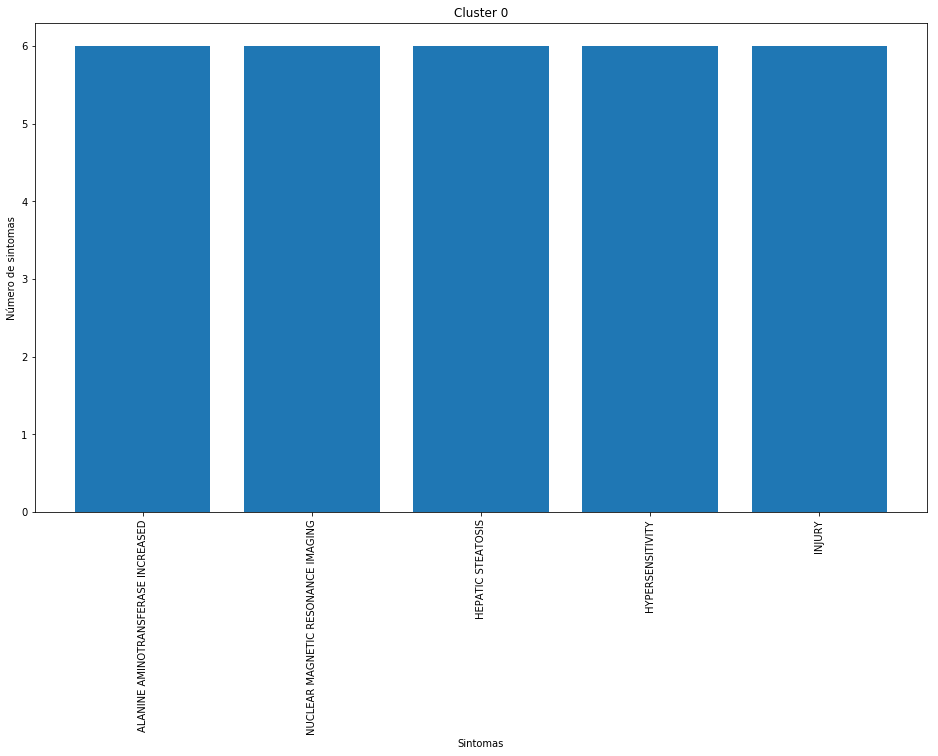

Cluster 1
    Count                                Industry
11     24  Vit/Min/Prot/Unconv Diet(Human/Animal)
2       6              Cereal Prep/Breakfast Food
7       4             Milk/Butter/Dried Milk Prod
10      2           Vegetables/Vegetable Products
0       1             Bakery Prod/Dough/Mix/Icing
1       1         Candy W/O Choc/Special/Chew Gum
3       1                         Choc/Cocoa Prod
4       1     Dietary Conv Food/Meal Replacements
5       1                      Dressing/Condiment
6       1                        Fruit/Fruit Prod
8       1                        Nuts/Edible Seed
9       1                        Soft Drink/Water
Temos 98 sintomas
    Count              Symptoms
1      45  ABDOMINAL DISTENSION
43     44               FATIGUE
3      14  ABDOMINAL PAIN UPPER
2      11        ABDOMINAL PAIN
28      9             DIARRHOEA


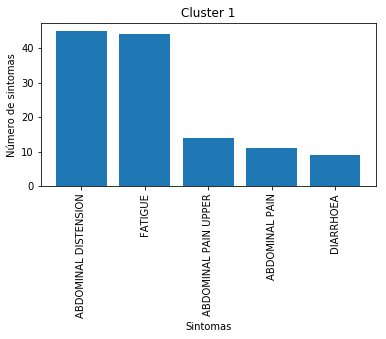

Cluster 2
   Count                                Industry
0     18  Vit/Min/Prot/Unconv Diet(Human/Animal)
Temos 18 sintomas
    Count                              Symptoms
0      18    ALANINE AMINOTRANSFERASE INCREASED
1      18  ASPARTATE AMINOTRANSFERASE INCREASED
16     18               URINARY TRACT INFECTION
15     18                      SKIN EXFOLIATION
14     18                              PRURITUS


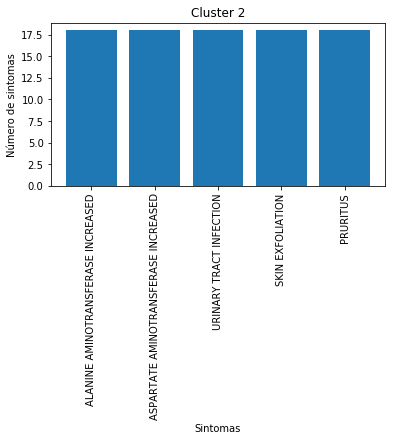

Cluster 3
    Count                                Industry
19    248  Vit/Min/Prot/Unconv Diet(Human/Animal)
6      11     Dietary Conv Food/Meal Replacements
15     10                        Soft Drink/Water
1       9             Bakery Prod/Dough/Mix/Icing
18      5           Vegetables/Vegetable Products
4       5                              Coffee/Tea
5       5                               Cosmetics
14      5                         Snack Food Item
8       5                    Fishery/Seafood Prod
12      5             Milk/Butter/Dried Milk Prod
11      4                        Fruit/Fruit Prod
0       4                          Baby Food Prod
2       3              Cereal Prep/Breakfast Food
13      2     Mult Food Dinner/Grav/Sauce/Special
3       2                         Choc/Cocoa Prod
16      2               Spices, Flavors And Salts
9       1              Food Additives (Human Use)
7       1              Filled Milk/Imit Milk Prod
17      1                  Vegetable Pro

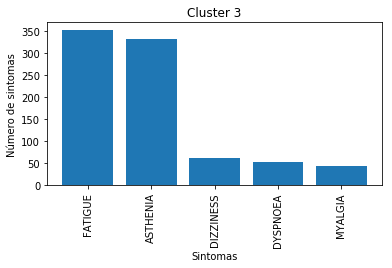

Cluster 4
   Count                                Industry
1     32  Vit/Min/Prot/Unconv Diet(Human/Animal)
0      1     Dietary Conv Food/Meal Replacements
Temos 55 sintomas
    Count     Symptoms
37     33     JAUNDICE
22     33  CHROMATURIA
30     33      FATIGUE
41     32       NAUSEA
45     30     PRURITUS


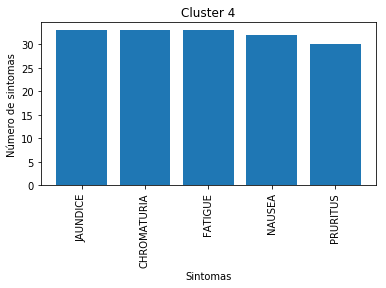

Cluster 5
   Count                                Industry
0     11  Vit/Min/Prot/Unconv Diet(Human/Animal)
Temos 30 sintomas
    Count                            Symptoms
0      11  ALANINE AMINOTRANSFERASE INCREASED
1      11     ATRIOVENTRICULAR BLOCK COMPLETE
28     11                        SINUS ARREST
27     11             PROTEIN TOTAL DECREASED
26     11                              PALLOR


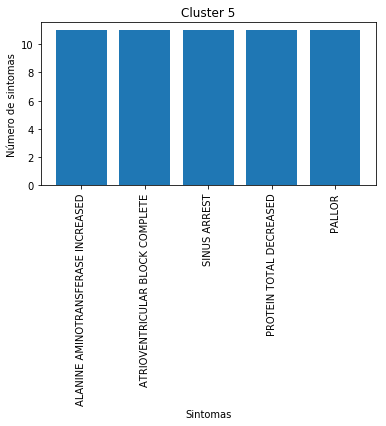

Cluster 6
   Count                                Industry
0     17  Vit/Min/Prot/Unconv Diet(Human/Animal)
Temos 30 sintomas
    Count           Symptoms
0      17  ADNEXA UTERI MASS
1      17  AMMONIA INCREASED
28     17      RENAL FAILURE
27     17         PRESYNCOPE
26     17       PANCREATITIS


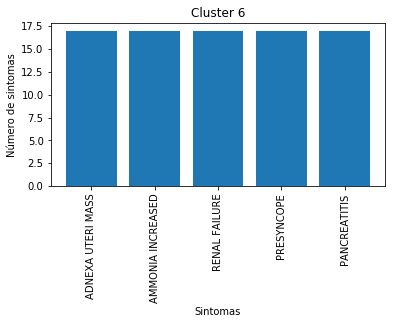

Cluster 7
    Count                                Industry
4      18                    Fishery/Seafood Prod
9      10     Mult Food Dinner/Grav/Sauce/Special
13      9           Vegetables/Vegetable Products
10      8                        Nuts/Edible Seed
6       4                        Fruit/Fruit Prod
0       3             Bakery Prod/Dough/Mix/Icing
7       3                          Ice Cream Prod
14      3  Vit/Min/Prot/Unconv Diet(Human/Animal)
8       2             Milk/Butter/Dried Milk Prod
12      2                         Snack Food Item
1       1                         Choc/Cocoa Prod
2       1                              Coffee/Tea
3       1     Dietary Conv Food/Meal Replacements
5       1              Food Additives (Human Use)
11      1                         Prep Salad Prod
Temos 111 sintomas
     Count                            Symptoms
27      68                           DIARRHOEA
36      67                             FATIGUE
38      59  FEELING OF BODY TE

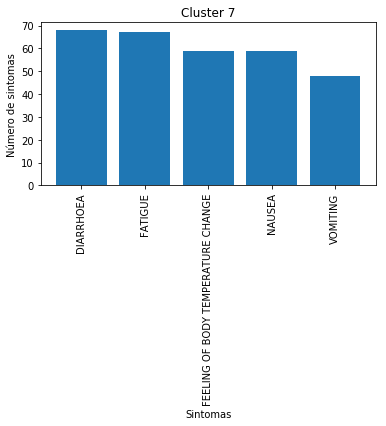

Cluster 8
   Count                                Industry
1    107  Vit/Min/Prot/Unconv Diet(Human/Animal)
0      1     Dietary Conv Food/Meal Replacements
Temos 140 sintomas
    Count                              Symptoms
15    112  ASPARTATE AMINOTRANSFERASE INCREASED
5     109    ALANINE AMINOTRANSFERASE INCREASED
56    108                               FATIGUE
23    105             BLOOD BILIRUBIN INCREASED
22     84  BLOOD ALKALINE PHOSPHATASE INCREASED


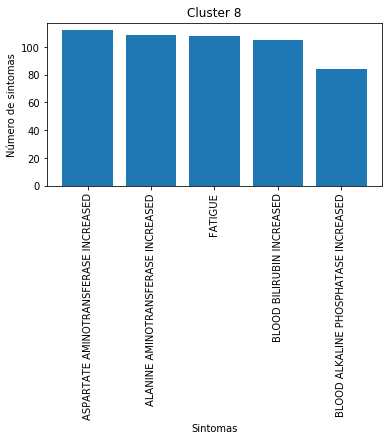

Cluster 9
   Count                                Industry
1      5  Vit/Min/Prot/Unconv Diet(Human/Animal)
0      1                        Soft Drink/Water
Temos 53 sintomas
    Count                         Symptoms
0       6            ACUTE HEPATIC FAILURE
27      6                HYPOPHOSPHATAEMIA
29      6                         INSOMNIA
30      6  INTRACRANIAL PRESSURE INCREASED
31      6                  LACTIC ACIDOSIS


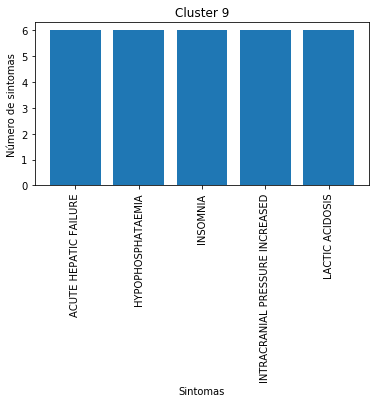

Cluster 10
    Count                                Industry
20     28  Vit/Min/Prot/Unconv Diet(Human/Animal)
19     17           Vegetables/Vegetable Products
9       9                    Fishery/Seafood Prod
1       9             Bakery Prod/Dough/Mix/Icing
15      8                        Nuts/Edible Seed
14      5     Mult Food Dinner/Grav/Sauce/Special
17      4                        Soft Drink/Water
13      4             Milk/Butter/Dried Milk Prod
10      4                        Fruit/Fruit Prod
6       4     Dietary Conv Food/Meal Replacements
4       3                         Choc/Cocoa Prod
18      3                  Vegetable Protein Prod
2       3              Cereal Prep/Breakfast Food
5       2                              Coffee/Tea
16      2                         Snack Food Item
3       2                      Cheese/Cheese Prod
8       1                            Egg/Egg Prod
7       1                      Dressing/Condiment
11      1                          Ice 

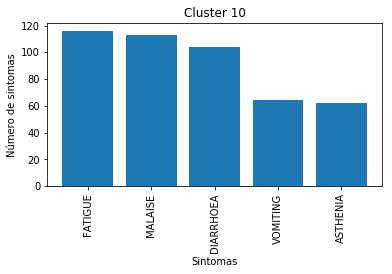

Cluster 11
   Count                                Industry
0      3  Vit/Min/Prot/Unconv Diet(Human/Animal)
Temos 16 sintomas
   Count                              Symptoms
8      6             DRUG-INDUCED LIVER INJURY
0      3    ALANINE AMINOTRANSFERASE INCREASED
1      3        ANTINUCLEAR ANTIBODY INCREASED
2      3  ASPARTATE AMINOTRANSFERASE INCREASED
3      3                  AUTOIMMUNE HEPATITIS


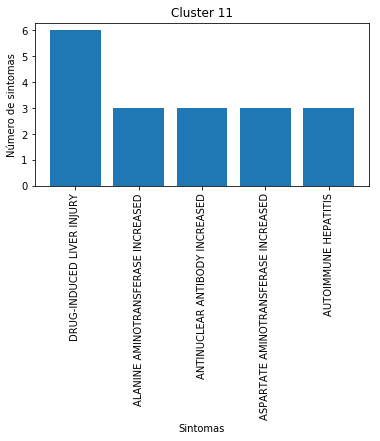

Cluster 12
    Count                                Industry
21    176  Vit/Min/Prot/Unconv Diet(Human/Animal)
20     14           Vegetables/Vegetable Products
6      10                               Cosmetics
17      9                        Soft Drink/Water
0       8             Bakery Prod/Dough/Mix/Icing
5       7                              Coffee/Tea
8       7                    Fishery/Seafood Prod
16      7                         Prep Salad Prod
11      6                        Fruit/Fruit Prod
15      5                        Nuts/Edible Seed
9       4              Food Additives (Human Use)
4       4                         Choc/Cocoa Prod
7       4     Dietary Conv Food/Meal Replacements
12      3         Meat, Meat Products and Poultry
14      3     Mult Food Dinner/Grav/Sauce/Special
19      3               Spices, Flavors And Salts
3       2                      Cheese/Cheese Prod
2       2              Cereal Prep/Breakfast Food
13      2             Milk/Butter/Dried

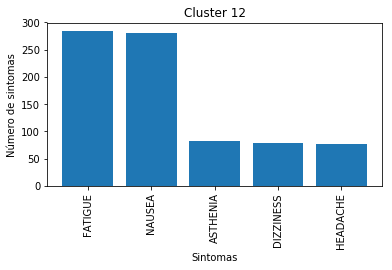

Cluster 13
   Count                                Industry
0     34  Vit/Min/Prot/Unconv Diet(Human/Animal)
Temos 7 sintomas
   Count                      Symptoms
0     34   BLOOD CHOLESTEROL INCREASED
1     34                       FATIGUE
2     34  LIVER FUNCTION TEST ABNORMAL
3     34                       MALAISE
4     34                 MUSCLE SPASMS


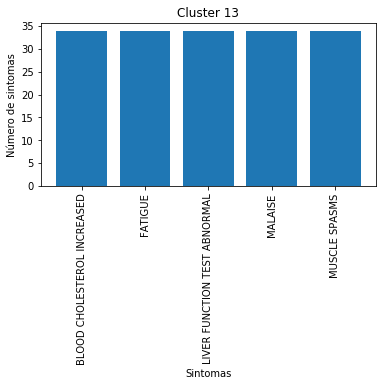

Cluster 14
    Count                                Industry
26    681  Vit/Min/Prot/Unconv Diet(Human/Animal)
7      24                               Cosmetics
8      22     Dietary Conv Food/Meal Replacements
22     21                        Soft Drink/Water
3      20              Cereal Prep/Breakfast Food
12     17              Food Additives (Human Use)
14     15                        Fruit/Fruit Prod
6      13                              Coffee/Tea
25      9           Vegetables/Vegetable Products
2       8         Candy W/O Choc/Special/Chew Gum
24      6               Spices, Flavors And Salts
17      5             Milk/Butter/Dried Milk Prod
0       5                          Baby Food Prod
5       5                         Choc/Cocoa Prod
1       4             Bakery Prod/Dough/Mix/Icing
11      4                    Fishery/Seafood Prod
21      4                         Snack Food Item
13      3             Food Sweeteners (Nutritive)
15      3                          Ice 

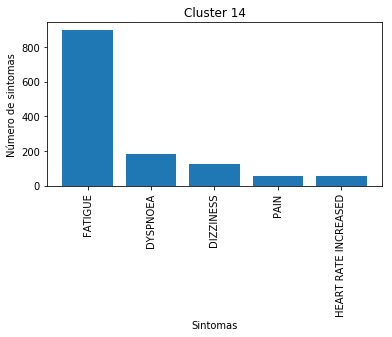

Cluster 15
    Count                                Industry
19    177  Vit/Min/Prot/Unconv Diet(Human/Animal)
8      10                    Fishery/Seafood Prod
2       6              Cereal Prep/Breakfast Food
14      6                        Nuts/Edible Seed
18      4           Vegetables/Vegetable Products
10      4                        Fruit/Fruit Prod
5       4                               Cosmetics
12      3             Milk/Butter/Dried Milk Prod
4       3                              Coffee/Tea
15      3                        Soft Drink/Water
0       3             Bakery Prod/Dough/Mix/Icing
7       2                            Egg/Egg Prod
9       2             Food Sweeteners (Nutritive)
6       1     Dietary Conv Food/Meal Replacements
1       1         Candy W/O Choc/Special/Chew Gum
11      1                          Ice Cream Prod
13      1     Mult Food Dinner/Grav/Sauce/Special
16      1               Spices, Flavors And Salts
17      1                          Vege

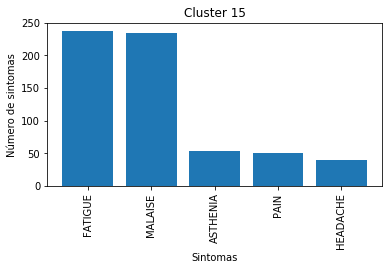

Cluster 16
   Count                                Industry
0      6  Vit/Min/Prot/Unconv Diet(Human/Animal)
Temos 38 sintomas
    Count                           Symptoms
34     12                    SUICIDE ATTEMPT
26     12  LOW DENSITY LIPOPROTEIN INCREASED
0       6                     ABDOMINAL PAIN
28      6                              MIXED
21      6               HEART RATE IRREGULAR


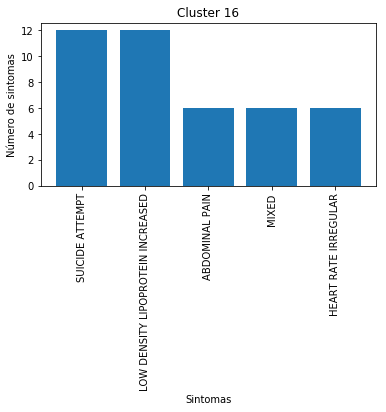

Cluster 17
   Count                                Industry
4    169  Vit/Min/Prot/Unconv Diet(Human/Animal)
1      3     Dietary Conv Food/Meal Replacements
0      2                              Coffee/Tea
2      1                    Fishery/Seafood Prod
3      1                        Soft Drink/Water
Temos 169 sintomas
     Count                   Symptoms
62     176                    FATIGUE
110    165                   JAUNDICE
122    106                     NAUSEA
37      81                CHROMATURIA
26      75  BLOOD BILIRUBIN INCREASED


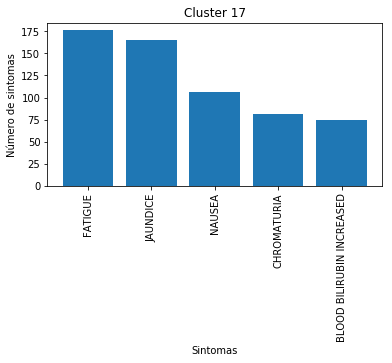

Cluster 18
   Count                                Industry
2      7  Vit/Min/Prot/Unconv Diet(Human/Animal)
0      3     Dietary Conv Food/Meal Replacements
1      1                        Soft Drink/Water
Temos 20 sintomas
    Count              Symptoms
10     11               FATIGUE
12     11  HEART RATE INCREASED
16     11          PARAESTHESIA
13     11         HYPOAESTHESIA
3      10   ATRIAL FIBRILLATION


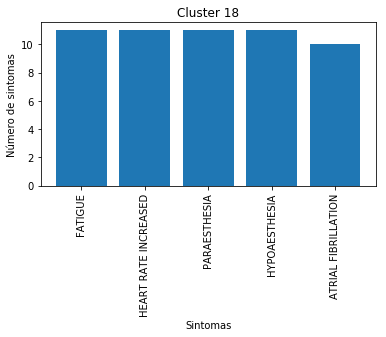

Cluster 19
   Count                                Industry
0     23  Vit/Min/Prot/Unconv Diet(Human/Animal)
Temos 12 sintomas
   Count                  Symptoms
9     46           SPEECH DISORDER
0     23  BLOOD PRESSURE INCREASED
1     23  CEREBROVASCULAR ACCIDENT
2     23               DEHYDRATION
3     23                 DIZZINESS


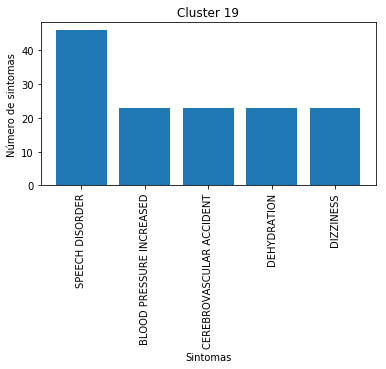

Cluster 20
   Count                                Industry
1      8  Vit/Min/Prot/Unconv Diet(Human/Animal)
0      1              Cereal Prep/Breakfast Food
Temos 12 sintomas
   Count              Symptoms
0      9  ABDOMINAL PAIN UPPER
1      9     CONFUSIONAL STATE
2      9             DIARRHOEA
3      9             DIZZINESS
4      9               FATIGUE


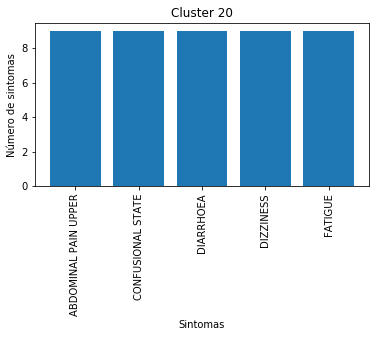

Cluster 21
   Count                    Industry
0      2  Food Additives (Human Use)
1      1            Soft Drink/Water
Temos 26 sintomas
    Count           Symptoms
11      6           HEADACHE
12      6      HYPERHIDROSIS
0       3     ABDOMINAL PAIN
14      3  MEMORY IMPAIRMENT
24      3   WALKING AID USER


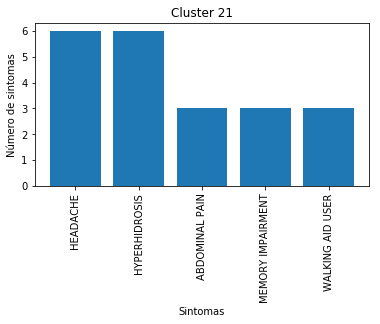

Cluster 22
   Count                                Industry
0     10  Vit/Min/Prot/Unconv Diet(Human/Animal)
Temos 20 sintomas
    Count                            Symptoms
0      10                      ABDOMINAL PAIN
1      10  ALANINE AMINOTRANSFERASE INCREASED
18     10                           ORAL PAIN
17     10                              NAUSEA
16     10                    NASAL CONGESTION


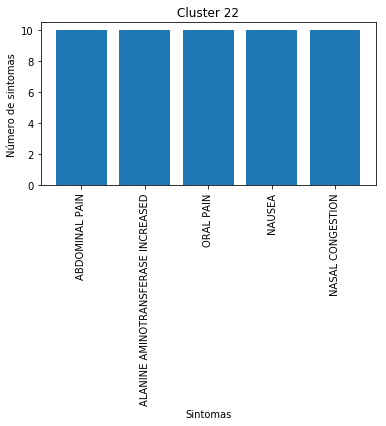

Cluster 23
   Count                                Industry
0     14  Vit/Min/Prot/Unconv Diet(Human/Animal)
Temos 11 sintomas
   Count          Symptoms
0     14  CHEST DISCOMFORT
1     14             COUGH
2     14        DERMATITIS
3     14          DYSPNOEA
4     14           FATIGUE


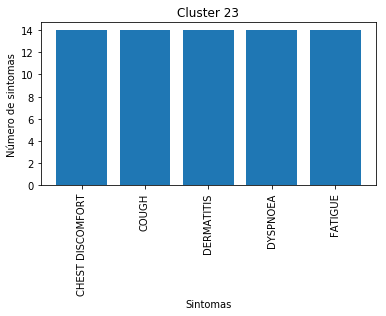

Cluster 24
    Count                                Industry
17     22           Vegetables/Vegetable Products
18     14  Vit/Min/Prot/Unconv Diet(Human/Animal)
12     10                        Nuts/Edible Seed
11      8     Mult Food Dinner/Grav/Sauce/Special
7       8                        Fruit/Fruit Prod
6       7                    Fishery/Seafood Prod
9       3         Meat, Meat Products and Poultry
10      2             Milk/Butter/Dried Milk Prod
16      2               Spices, Flavors And Salts
2       2              Cereal Prep/Breakfast Food
0       2             Bakery Prod/Dough/Mix/Icing
5       1                            Egg/Egg Prod
8       1                          Ice Cream Prod
1       1         Candy W/O Choc/Special/Chew Gum
4       1     Dietary Conv Food/Meal Replacements
3       1                         Choc/Cocoa Prod
13      1                         Prep Salad Prod
14      1                        Soft Drink/Water
15      1                              

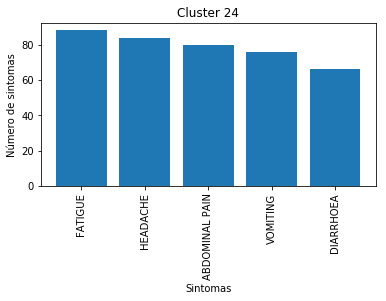

Cluster 25
   Count                                Industry
0      9  Vit/Min/Prot/Unconv Diet(Human/Animal)
Temos 12 sintomas
   Count                              Symptoms
0      9    ALANINE AMINOTRANSFERASE INCREASED
1      9  ASPARTATE AMINOTRANSFERASE INCREASED
2      9                              ASTHENIA
3      9             BLOOD BILIRUBIN INCREASED
4      9                           FAECES PALE


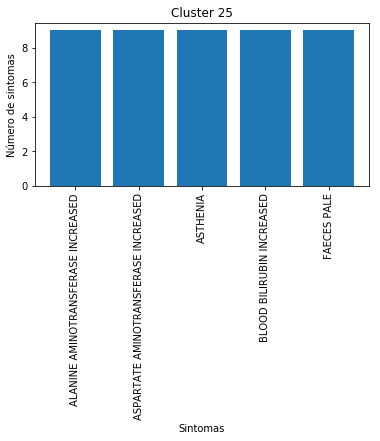

Cluster 26
   Count                                Industry
2      5  Vit/Min/Prot/Unconv Diet(Human/Animal)
0      1                        Nuts/Edible Seed
1      1           Vegetables/Vegetable Products
Temos 14 sintomas
   Count              Symptoms
7     14     MUSCULAR WEAKNESS
9     14          PARAESTHESIA
0      7  ABDOMINAL PAIN LOWER
1      7            ARTHRALGIA
2      7      BALANCE DISORDER


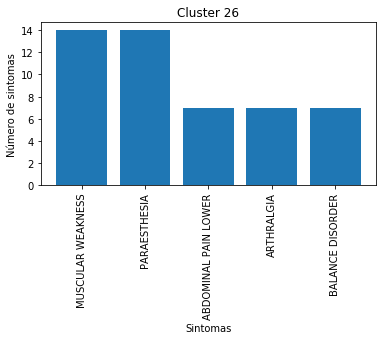

Cluster 27
   Count                                Industry
0      6  Vit/Min/Prot/Unconv Diet(Human/Animal)
Temos 18 sintomas
    Count                                     Symptoms
0       6           ALANINE AMINOTRANSFERASE INCREASED
1       6                      BLOOD ALBUMIN DECREASED
16      6                             WEIGHT DECREASED
15      6                      TRANSAMINASES INCREASED
14      6  RED BLOOD CELL SEDIMENTATION RATE INCREASED


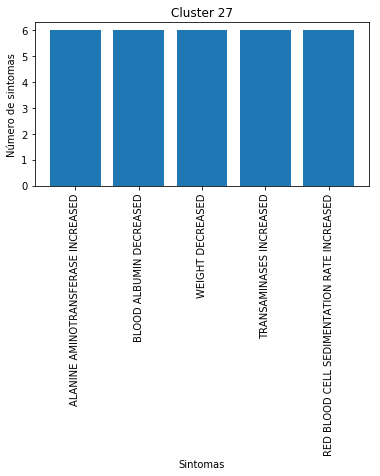

Cluster 28
   Count                                Industry
0      5  Vit/Min/Prot/Unconv Diet(Human/Animal)
Temos 15 sintomas
   Count                    Symptoms
0      5  BODY TEMPERATURE INCREASED
1      5          DECREASED APPETITE
2      5          EMOTIONAL DISTRESS
3      5                     FATIGUE
4      5                   GASTRITIS


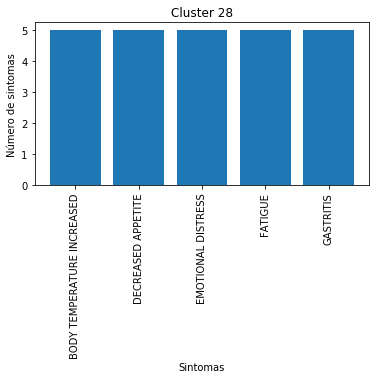

Cluster 29
   Count                   Industry
0     17           Soft Drink/Water
1      8  Spices, Flavors And Salts
Temos 25 sintomas
    Count  Symptoms
8      26   FATIGUE
11     25  HEADACHE
4      25    CHILLS
14     25    NAUSEA
22     25   VERTIGO


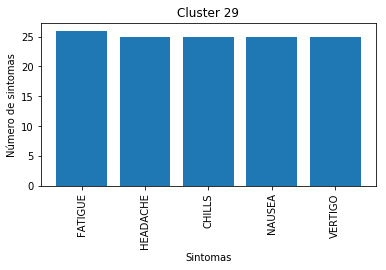

Cluster 30
    Count                                Industry
19    137  Vit/Min/Prot/Unconv Diet(Human/Animal)
16     17                        Soft Drink/Water
5       6                               Cosmetics
9       6              Food Additives (Human Use)
1       5         Candy W/O Choc/Special/Chew Gum
6       4     Dietary Conv Food/Meal Replacements
13      4             Milk/Butter/Dried Milk Prod
8       4                    Fishery/Seafood Prod
0       3             Bakery Prod/Dough/Mix/Icing
18      3           Vegetables/Vegetable Products
10      3             Food Sweeteners (Nutritive)
4       3                              Coffee/Tea
2       3              Cereal Prep/Breakfast Food
20      3    Whole Grain/Milled Grain Prod/Starch
11      2                        Fruit/Fruit Prod
12      1                          Ice Cream Prod
7       1                            Egg/Egg Prod
14      1                        Nuts/Edible Seed
15      1                         Snack

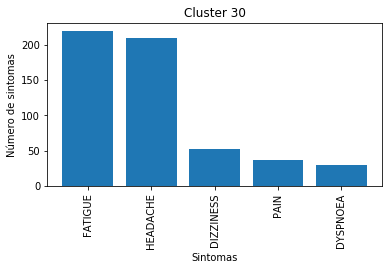

Cluster 31
    Count                                Industry
19     69  Vit/Min/Prot/Unconv Diet(Human/Animal)
18     17           Vegetables/Vegetable Products
1      16             Bakery Prod/Dough/Mix/Icing
12      9     Mult Food Dinner/Grav/Sauce/Special
13      9                        Nuts/Edible Seed
11      8             Milk/Butter/Dried Milk Prod
9       7                        Fruit/Fruit Prod
2       5              Cereal Prep/Breakfast Food
7       5                    Fishery/Seafood Prod
10      4                          Ice Cream Prod
4       4                              Coffee/Tea
14      4                         Snack Food Item
3       3                      Cheese/Cheese Prod
15      2                        Soft Drink/Water
16      1                                    Soup
17      1               Spices, Flavors And Salts
0       1                          Baby Food Prod
8       1              Food Additives (Human Use)
6       1                            Eg

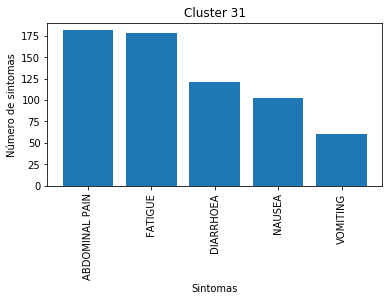

Cluster 32
   Count                                Industry
0     38  Vit/Min/Prot/Unconv Diet(Human/Animal)
Temos 38 sintomas
    Count     Symptoms
34     40     PRURITUS
10     38  CHROMATURIA
15     38      FATIGUE
25     37     JAUNDICE
37     33     VOMITING


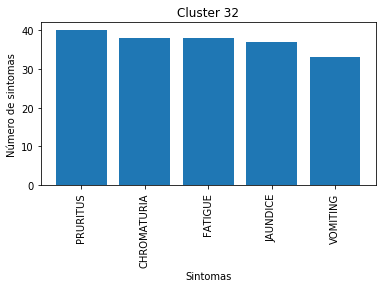

Cluster 33
   Count                                Industry
1     23  Vit/Min/Prot/Unconv Diet(Human/Animal)
0      2     Dietary Conv Food/Meal Replacements
Temos 10 sintomas
   Count                              Symptoms
0     25    ALANINE AMINOTRANSFERASE INCREASED
1     25  ASPARTATE AMINOTRANSFERASE INCREASED
2     25                              ASTHENIA
5     25                               FATIGUE
6     25              HEPATIC ENZYME INCREASED


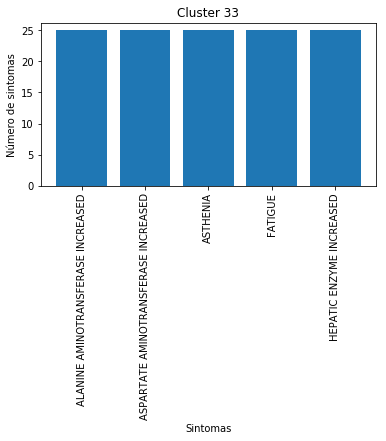

Cluster 34
   Count                                Industry
4      5  Vit/Min/Prot/Unconv Diet(Human/Animal)
1      2     Dietary Conv Food/Meal Replacements
2      2                    Fishery/Seafood Prod
0      1         Candy W/O Choc/Special/Chew Gum
3      1                        Fruit/Fruit Prod
Temos 23 sintomas
    Count                          Symptoms
0      11                    ABDOMINAL PAIN
9      11                           FATIGUE
14     11                            NAUSEA
3      11                         BACK PAIN
22      8  WHITE BLOOD CELL COUNT INCREASED


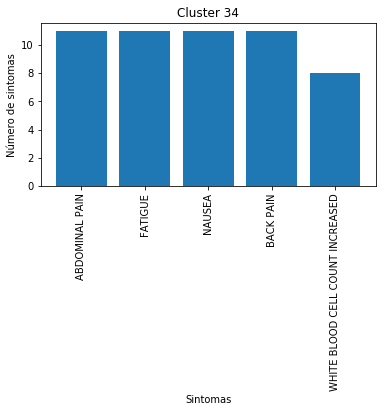

Cluster 35
   Count                                Industry
0     13  Vit/Min/Prot/Unconv Diet(Human/Animal)
Temos 16 sintomas
   Count               Symptoms
6     26       FEELING ABNORMAL
8     26               FLUSHING
0     13  ADRENAL INSUFFICIENCY
1     13                ANXIETY
2     13                 ASTHMA


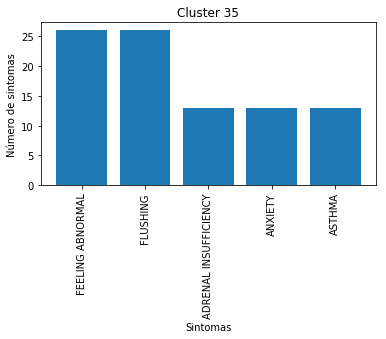

Cluster 36
   Count                                Industry
0      7  Vit/Min/Prot/Unconv Diet(Human/Animal)
Temos 10 sintomas
   Count                             Symptoms
0      7  ACTIVITIES OF DAILY LIVING IMPAIRED
1      7              BLOOD CALCIUM INCREASED
2      7            BLOOD MAGNESIUM INCREASED
3      7                    CONFUSIONAL STATE
4      7                   DECREASED APPETITE


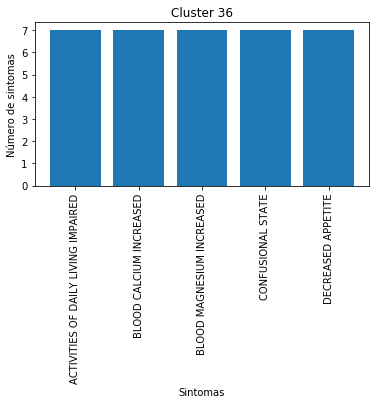

Cluster 37
   Count                                Industry
0     16  Vit/Min/Prot/Unconv Diet(Human/Animal)
Temos 20 sintomas
    Count          Symptoms
6      16           FATIGUE
13     16      PALPITATIONS
4      15  CHEST DISCOMFORT
12     14           MALAISE
7      13  FEELING ABNORMAL


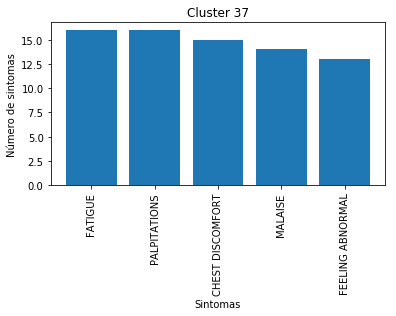

Cluster 38
    Count                                Industry
24     89  Vit/Min/Prot/Unconv Diet(Human/Animal)
23     19           Vegetables/Vegetable Products
11     18                    Fishery/Seafood Prod
13     15                        Fruit/Fruit Prod
16     11             Milk/Butter/Dried Milk Prod
18     10                        Nuts/Edible Seed
4       9              Cereal Prep/Breakfast Food
17      9     Mult Food Dinner/Grav/Sauce/Special
21      8                        Soft Drink/Water
1       8                          Baby Food Prod
20      7                         Snack Food Item
14      7                          Ice Cream Prod
2       6             Bakery Prod/Dough/Mix/Icing
8       5     Dietary Conv Food/Meal Replacements
3       4         Candy W/O Choc/Special/Chew Gum
6       4                              Coffee/Tea
9       4                            Egg/Egg Prod
7       3                               Cosmetics
15      3         Meat, Meat Products a

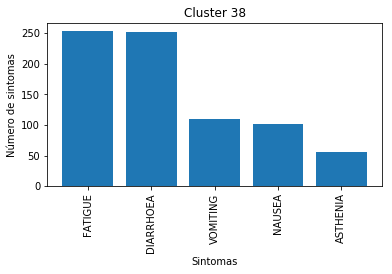

Cluster 39
   Count                                Industry
1      9  Vit/Min/Prot/Unconv Diet(Human/Animal)
0      1     Dietary Conv Food/Meal Replacements
Temos 19 sintomas
    Count                            Symptoms
0      10  ALANINE AMINOTRANSFERASE INCREASED
10     10            HEPATIC ENZYME INCREASED
17     10                 VARICES OESOPHAGEAL
16     10           ULTRASOUND LIVER ABNORMAL
15     10         ULTRASOUND ABDOMEN ABNORMAL


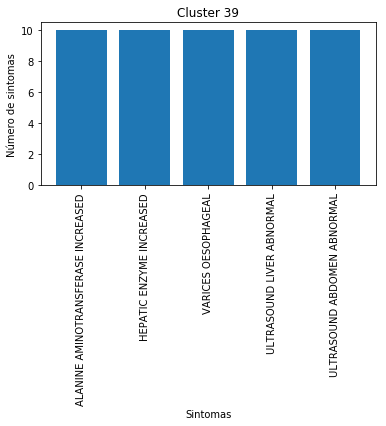

Cluster 40
   Count                                Industry
0      5  Vit/Min/Prot/Unconv Diet(Human/Animal)
Temos 17 sintomas
    Count                            Symptoms
9      10  HEPATITIS B CORE ANTIBODY POSITIVE
0       5                   ACUTE HEPATITIS B
15      5                            PRURITUS
14      5                              NAUSEA
13      5        LIVER FUNCTION TEST ABNORMAL


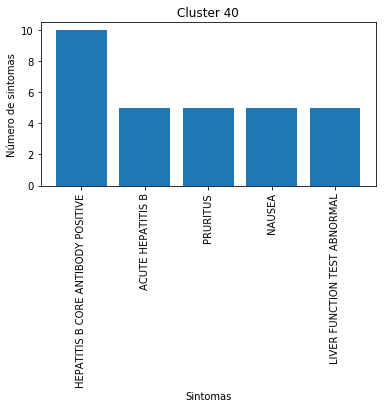

Cluster 41
   Count                                Industry
2      6  Vit/Min/Prot/Unconv Diet(Human/Animal)
0      3                         Choc/Cocoa Prod
1      1                              Coffee/Tea
Temos 37 sintomas
    Count            Symptoms
36     10    WEIGHT DECREASED
9      10  DECREASED APPETITE
12     10             FATIGUE
10     10          DEPRESSION
32      8      SLEEP DISORDER


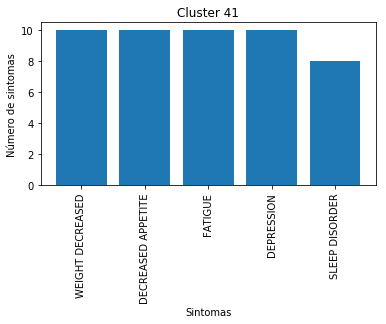

Cluster 42
   Count                                Industry
0      8  Vit/Min/Prot/Unconv Diet(Human/Animal)
Temos 18 sintomas
    Count                            Symptoms
8      16                             FATIGUE
0       8  ALANINE AMINOTRANSFERASE INCREASED
10      8                    HEPATIC NECROSIS
16      8     SMOOTH MUSCLE ANTIBODY POSITIVE
15      8                        LIVER INJURY


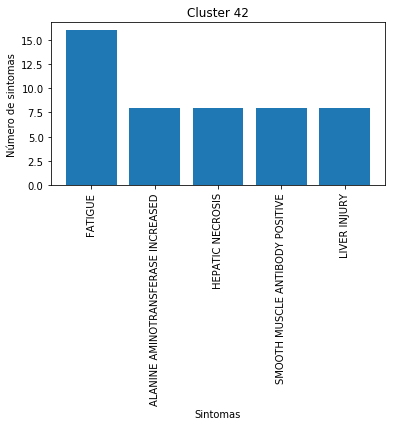

Cluster 43
   Count                                Industry
1      3  Vit/Min/Prot/Unconv Diet(Human/Animal)
0      1                        Soft Drink/Water
Temos 18 sintomas
    Count                                Symptoms
0       4                               AGITATION
1       4  BLOOD CREATINE PHOSPHOKINASE INCREASED
16      4                                VOMITING
15      4                                 SYNCOPE
14      4                                  STRESS


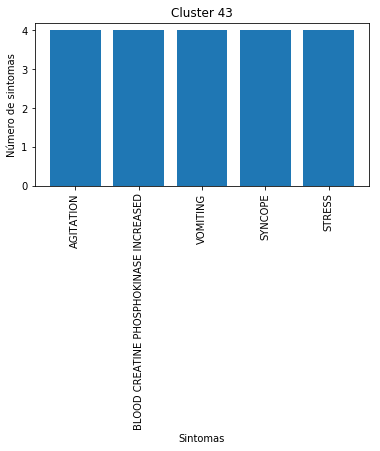

Cluster 44
   Count                                Industry
1     12  Vit/Min/Prot/Unconv Diet(Human/Animal)
0      4              Food Additives (Human Use)
Temos 7 sintomas
   Count                  Symptoms
0     16                AGGRESSION
1     16  DISTURBANCE IN ATTENTION
2     16                   FATIGUE
3     16                  LETHARGY
4     16                  MIGRAINE


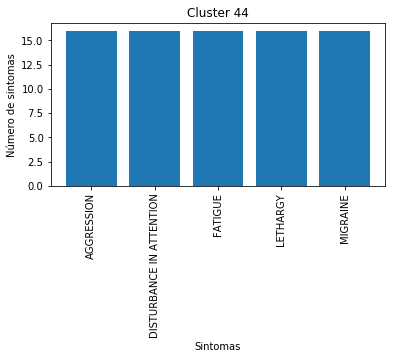

Cluster 45
   Count                                Industry
0     11  Vit/Min/Prot/Unconv Diet(Human/Animal)
Temos 14 sintomas
   Count                              Symptoms
5     44  BLOOD ALKALINE PHOSPHATASE INCREASED
3     22    ALANINE AMINOTRANSFERASE INCREASED
4     22  ASPARTATE AMINOTRANSFERASE INCREASED
0     11                        ABDOMINAL PAIN
1     11                  ABDOMINAL PAIN UPPER


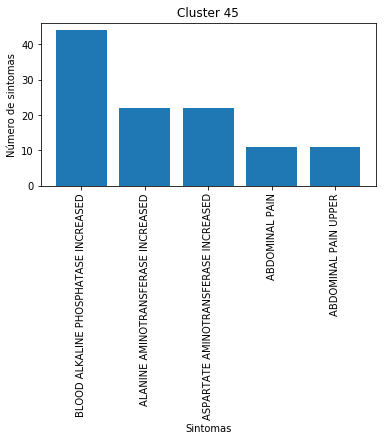

Cluster 46
   Count                                Industry
0     11  Vit/Min/Prot/Unconv Diet(Human/Animal)
Temos 27 sintomas
    Count                      Symptoms
2      11                      ASTHENIA
8      11                       FATIGUE
21     11                        NAUSEA
18     11  LIVER FUNCTION TEST ABNORMAL
17     11                LIVER DISORDER


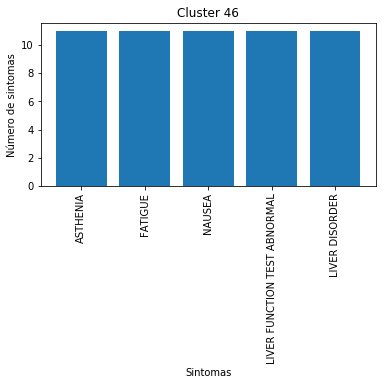

Cluster 47
   Count                                Industry
0      7  Vit/Min/Prot/Unconv Diet(Human/Animal)
Temos 8 sintomas
   Count       Symptoms
0      7    BLOOD URINE
1      7        DYSURIA
2      7        FATIGUE
3      7  HALLUCINATION
4      7       INSOMNIA


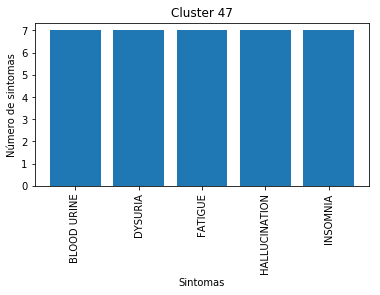

Cluster 48
   Count                                Industry
0      3  Vit/Min/Prot/Unconv Diet(Human/Animal)
Temos 21 sintomas
    Count                            Symptoms
16      6                            PRURITUS
0       3  ALANINE AMINOTRANSFERASE INCREASED
11      3                        HEPATOMEGALY
19      3               TRANSFERRIN INCREASED
18      3            SERUM FERRITIN INCREASED


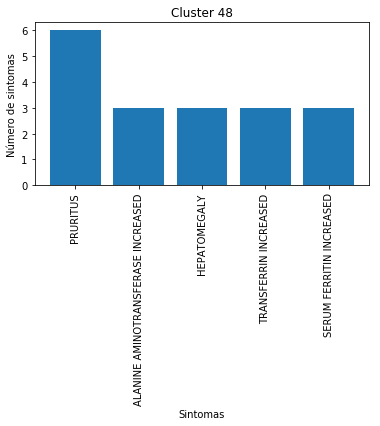

Cluster 49
   Count                                Industry
0      7  Vit/Min/Prot/Unconv Diet(Human/Animal)
Temos 7 sintomas
   Count                    Symptoms
0      7        ABDOMINAL PAIN UPPER
1      7    BLOOD PRESSURE INCREASED
2      7  BODY TEMPERATURE INCREASED
3      7                     FATIGUE
4      7                 NERVOUSNESS


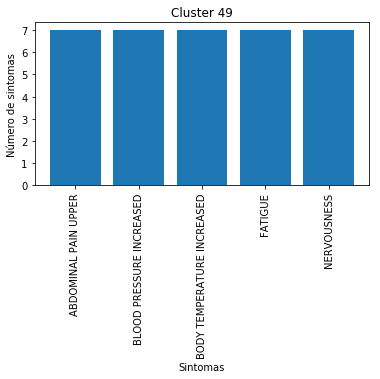

In [17]:

def plot_clust_symptoms(data, i):
    array_all_symptoms = np.concatenate( [str(symptom).split(',') for symptom in data[data['KMeans Group']==i]['One Row Coded Symptoms']], axis=0 )
    #Remove some spaces
    array_all_symptoms, counts = np.unique([o.lstrip() for o in array_all_symptoms], return_counts=True)
    ordered_symptoms_count = pd.DataFrame({'Symptoms': array_all_symptoms, 'Count': counts}).sort_values(by='Count', ascending=False)
    print('Temos',len(array_all_symptoms), 'sintomas')
    top = 5
    print(ordered_symptoms_count[:top])

    #Histograma dos resultados
    plt.bar(ordered_symptoms_count['Symptoms'][:top], ordered_symptoms_count['Count'][:top])
    plt.gca().set_xticks(ordered_symptoms_count['Symptoms'][:top])
    plt.xticks(rotation=90)
    plt.rcParams["figure.figsize"] = [6,3]
    plt.xlabel('Sintomas')
    plt.ylabel('Número de sintomas')
    plt.title('Cluster '+str(i))
    plt.show()


for i in range(num_clusters):
    industry, counts = np.unique(data_relevant_symptoms[data_relevant_symptoms['KMeans Group']==i]['Industry Name'],return_counts=True)
    ordered_industry_count = pd.DataFrame({'Industry': industry, 'Count': counts}).sort_values(by='Count', ascending=False)
    print('Cluster',i)
    print(ordered_industry_count)
    
    plot_clust_symptoms(data_relevant_symptoms, i)
    #symptoms, sym_counts = np.unique(data_relevant_symptoms[data_relevant_symptoms['KMeans Group']==i]['One Row Coded Symptoms'],return_counts=True)
    #ordered_symptom_count = pd.DataFrame({'Symptom': symptoms, 'Count': sym_counts}).sort_values(by='Count', ascending=False)
    #print(ordered_symptom_count)
